Data source :https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In this notebook , CNN Models are built for the purpose of accurately identifying the malaria cells , whether infected/parasitised or uninfected.  

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
data_dir = "../input/cell-images-for-detecting-malaria/cell_images/cell_images" 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 20669 files for training.


In [4]:
class_names = train_ds.class_names
print(class_names)


['Parasitized', 'Uninfected']


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 6889 files for validation.


In [7]:
def get_class(val, dictionary):
    for key,values in dictionary.items():
        if val == values:
            return key
    return

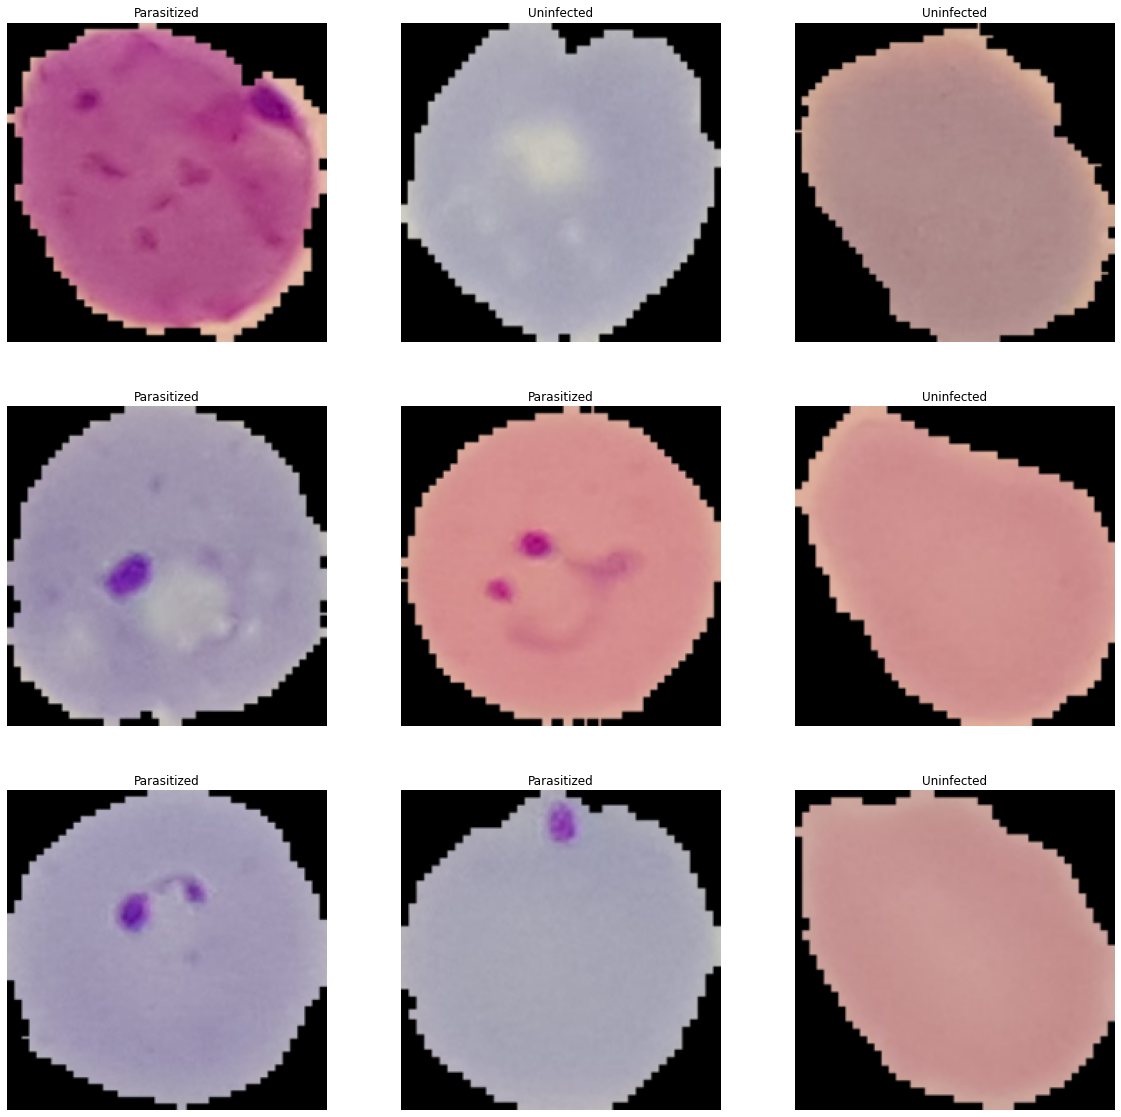

In [7]:
## visualize train set images
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

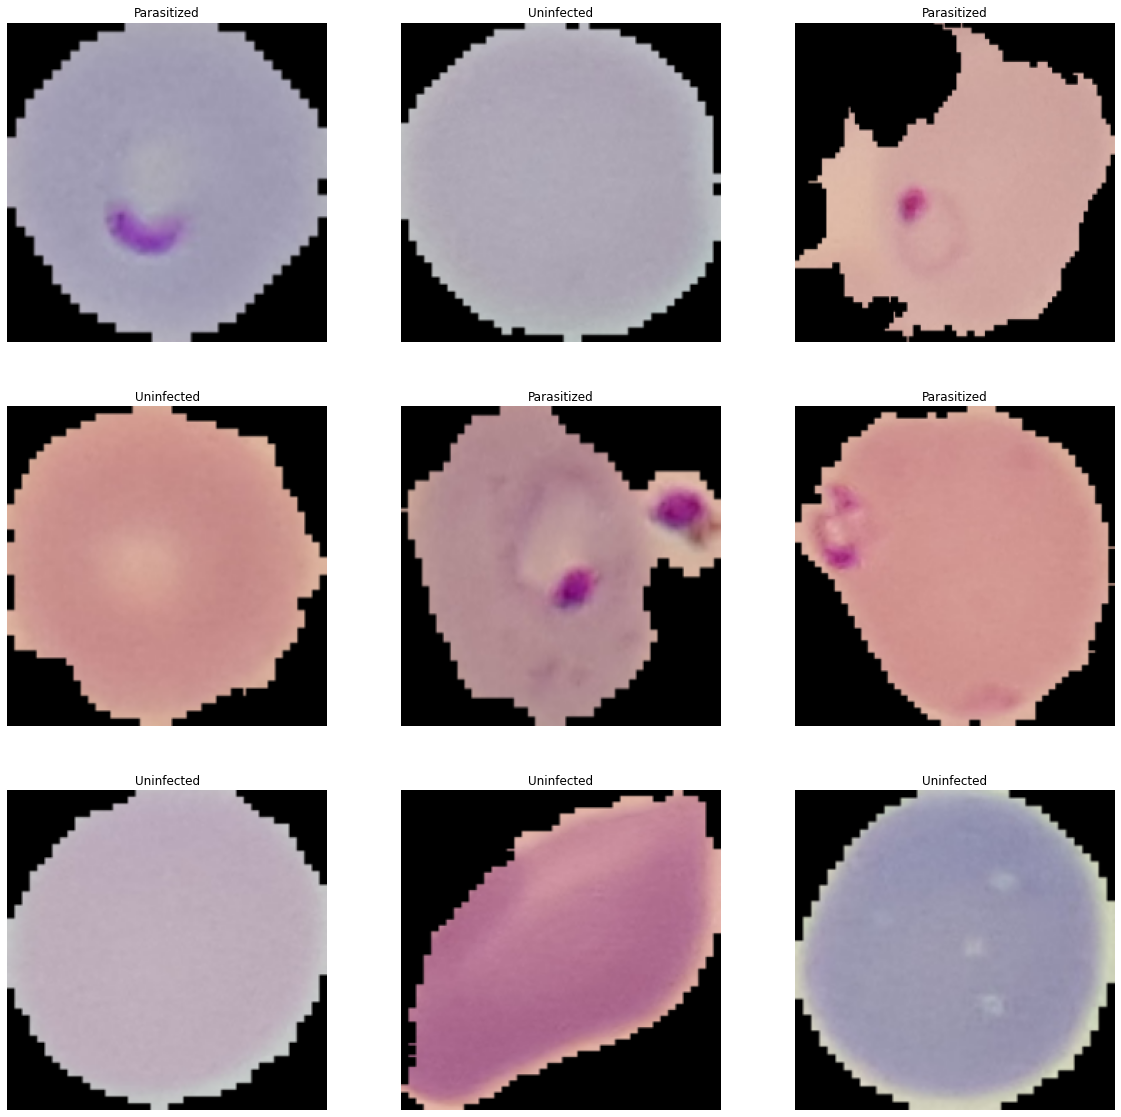

In [8]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")


In [8]:
## train image data set , convert into array so that it can be split into train and validation sets 
## while fitting 


train_labels = np.array([])
train_images = []
i = 0

for x, y in train_ds:
    n = x.shape[0]
    train_labels = np.concatenate([train_labels , y.numpy()])
    for j in range(n):
            train_images.append(x[j].numpy().astype("uint8"))
train_images = np.array(train_images)

In [9]:
train_images.shape

(20669, 224, 224, 3)

In [10]:
train_labels.shape

(20669,)

CPU times: user 6min 46s, sys: 32.1 s, total: 7min 18s
Wall time: 9min 14s
216/216 [==============================] - 14s 63ms/step - loss: 0.5198 - accuracy: 0.9032
Test image accuracy :0.9031789898872375
Classification Report
              precision    recall  f1-score   support

 Parasitized       0.92      0.88      0.90      3398
  Uninfected       0.89      0.92      0.91      3491

    accuracy                           0.90      6889
   macro avg       0.90      0.90      0.90      6889
weighted avg       0.90      0.90      0.90      6889

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling

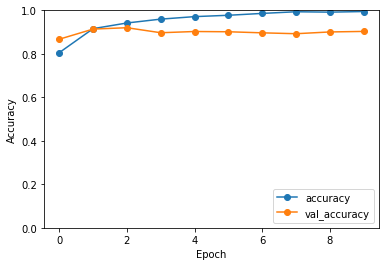

In [12]:
## single layer CNN 

##
model = tf.keras.models.Sequential([
     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 32, kernel_size = 3),
tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_ds,  epochs=10, validation_data = val_ds , verbose = 0)
##
test_loss, test_acc = model.evaluate(val_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn1')
##
## for test data set , check the classification report.
test_pred = np.array([])
test_labels = np.array([])
for x, y in val_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    test_pred = np.concatenate([test_pred,np.array(predictions)])
    test_labels = np.concatenate([test_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(test_labels, test_pred, target_names=class_names))
##
print(model.summary())
##
print("Confusion Matrix :\n")
print(confusion_matrix(test_labels, test_pred))

Accuracy is high at 0.9 , but there must be scope for improvements .  

CPU times: user 1min 20s, sys: 5.3 s, total: 1min 25s
Wall time: 1min 36s
216/216 [==============================] - 48s 218ms/step - loss: 0.6335 - accuracy: 0.8339
Test image accuracy :0.8339381814002991
Classification Report
              precision    recall  f1-score   support

 Parasitized       0.81      0.87      0.84      3398
  Uninfected       0.86      0.80      0.83      3491

    accuracy                           0.83      6889
   macro avg       0.84      0.83      0.83      6889
weighted avg       0.84      0.83      0.83      6889

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) 

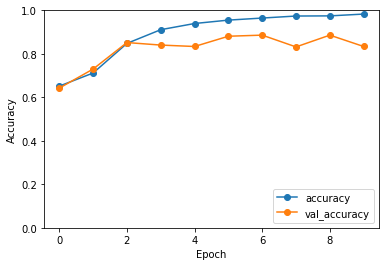

In [13]:
## two layer CNN 

##
model = tf.keras.models.Sequential([
     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 32, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 32, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.BatchNormalization(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_images,train_labels,  epochs=10, validation_split = 0.2 , verbose = 0)
##
test_loss, test_acc = model.evaluate(val_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn1')
##
## for test data set , check the classification report.
test_pred = np.array([])
test_labels = np.array([])
for x, y in val_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    test_pred = np.concatenate([test_pred,np.array(predictions)])
    test_labels = np.concatenate([test_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(test_labels, test_pred, target_names=class_names))
##
print(model.summary())
##
print("Confusion Matrix :\n")
print(confusion_matrix(test_labels, test_pred))

Accuracy has come down with two layers of CNN + Max Pooling.

CPU times: user 42.3 s, sys: 3.62 s, total: 46 s
Wall time: 40.5 s
216/216 [==============================] - 13s 59ms/step - loss: 0.4949 - accuracy: 0.9287
Test image accuracy :0.9287269711494446
Classification Report
              precision    recall  f1-score   support

 Parasitized       0.95      0.90      0.93      3398
  Uninfected       0.91      0.96      0.93      3491

    accuracy                           0.93      6889
   macro avg       0.93      0.93      0.93      6889
weighted avg       0.93      0.93      0.93      6889

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None,

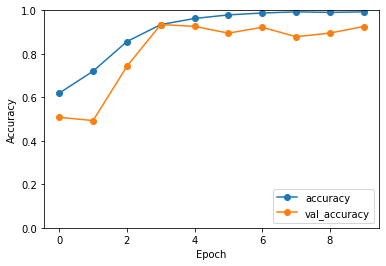

In [14]:
## three layer CNN with fewer filters.

##
model = tf.keras.models.Sequential([
     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 4, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 6, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 10, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.BatchNormalization(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_images,train_labels,  epochs=10, validation_split = 0.2 , verbose = 0)
##
test_loss, test_acc = model.evaluate(val_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn1')
##
## for test data set , check the classification report.
test_pred = np.array([])
test_labels = np.array([])
for x, y in val_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    test_pred = np.concatenate([test_pred,np.array(predictions)])
    test_labels = np.concatenate([test_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(test_labels, test_pred, target_names=class_names))
##
print(model.summary())
##
print("Confusion Matrix :\n")
print(confusion_matrix(test_labels, test_pred))

Recall for Paracetised class is low at 0.9 though accuracy is 0.93. 

CPU times: user 41.1 s, sys: 4.43 s, total: 45.5 s
Wall time: 46.1 s
216/216 [==============================] - 33s 144ms/step - loss: 1.2411 - accuracy: 0.8229
Test image accuracy :0.8229060769081116
Classification Report
              precision    recall  f1-score   support

 Parasitized       0.79      0.86      0.83      3398
  Uninfected       0.86      0.78      0.82      3491

    accuracy                           0.82      6889
   macro avg       0.83      0.82      0.82      6889
weighted avg       0.83      0.82      0.82      6889

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None

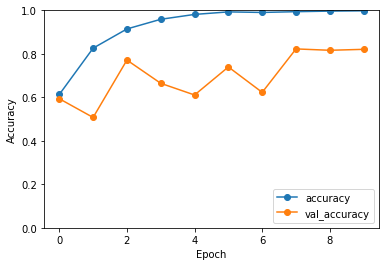

In [11]:
## two layer CNN with fewer filters.

##
model = tf.keras.models.Sequential([
     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 4, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 6, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.BatchNormalization(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_images,train_labels,  epochs=10, validation_split = 0.2 , verbose = 0)
##
test_loss, test_acc = model.evaluate(val_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn1')
##
## for test data set , check the classification report.
test_pred = np.array([])
test_labels = np.array([])
for x, y in val_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    test_pred = np.concatenate([test_pred,np.array(predictions)])
    test_labels = np.concatenate([test_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(test_labels, test_pred, target_names=class_names))
##
print(model.summary())
##
print(confusion_matrix(test_labels, test_pred))

Two layer CNN + Max pooling has decreased the accuracy . 